# Setup

In [1]:
%pip install --upgrade pip -q
%pip install pandas scikit-learn imbalanced-learn scikit-optimize sklearn-genetic-opt matplotlib seaborn -q 

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import zipfile
import pandas as pd 
import numpy as np
import time
import traceback
import ast
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import clone
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.decomposition import PCA
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, cohen_kappa_score
from sklearn.neural_network import MLPClassifier
from skopt import BayesSearchCV  
from skopt.space import Categorical as SkoptCategorical
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Categorical as GeneticCategorical
from imblearn.over_sampling import SMOTE

c:\projetos\kaua\Trabalho_Topicos_10\.venv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
path_dataset = 'dataset'
path_dataset_zip = f'{path_dataset}/german.zip'
path_dataset_extracted = f'{path_dataset}/german'
path_dataset_file = f'{path_dataset_extracted}/german.data-numeric'
path_result_csv = 'result.csv'

In [4]:
os.makedirs(path_dataset, exist_ok=True)
if not os.path.exists(path_dataset_zip):
  !curl https://archive.ics.uci.edu/static/public/144/statlog+german+credit+data.zip -o {path_dataset_zip}
zipfile.ZipFile(path_dataset_zip).extractall(path_dataset_extracted)

In [5]:
df = pd.read_csv(path_dataset_file, header=None, sep='\s+')
df.head()

,0,1,2,3,4,5,6,7,8,9,...,15,16,17,18,19,20,21,22,23,24
0,1,6,4,12,5,5,3,4,1,67,...,0,0,1,0,0,1,0,0,1,1
1,2,48,2,60,1,3,2,2,1,22,...,0,0,1,0,0,1,0,0,1,2
2,4,12,4,21,1,4,3,3,1,49,...,0,0,1,0,0,1,0,1,0,1
3,1,42,2,79,1,4,3,4,2,45,...,0,0,0,0,0,0,0,0,1,1
4,1,24,3,49,1,3,3,4,4,53,...,1,0,1,0,0,0,0,0,1,2


# Pré processamento dos dados

In [6]:
# Vamos substituir os autlieres, por seus valores dos quartis (Nome do método: Winsorization)
X, y = df.iloc[:, :-1], df.iloc[:, -1]

X = X.copy()
for col in X.columns:
    Q1 = X[col].quantile(0.25)
    Q3 = X[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    X[col] = np.where(X[col] < lower_bound, Q1, X[col])
    X[col] = np.where(X[col] > upper_bound, Q3, X[col])

X_scalered = RobustScaler().fit_transform(X)
df.isnull().sum().sum()

np.int64(0)

In [7]:
X_pca = PCA(n_components=3).fit_transform(X_scalered)
X_pca.shape, X_scalered.shape 

((1000, 3), (1000, 24))

# Configuração dos experimentos

In [8]:


class MLPWrapper(MLPClassifier):
    def fit(self, X, y):
        if isinstance(self.hidden_layer_sizes, str):
            self.hidden_layer_sizes = ast.literal_eval(self.hidden_layer_sizes)
        return super().fit(X, y)

param_grids = {
    'RF': {
        'n_estimators': [50, 100, 200],
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'criterion': ['gini', 'entropy']
        # 3 * 4 * 3 * 2 = 72 combinações
    },
    'KNN': {
        'n_neighbors': [3, 5, 7, 9, 11],
        'weights': ['uniform', 'distance'],
        'metric': ['euclidean', 'manhattan']
        # 5 * 2 * 2 = 20 combinações
    },
    'SVM': {
        'C': [0.1, 1, 10, 100],
        'kernel': ['rbf', 'poly', 'sigmoid'],
        'gamma': ['scale', 'auto']
        # 4 * 3 * 2 = 24 combinações
    },
    'MLP': {
        'hidden_layer_sizes': ['(50,)', '(100,)', '(50, 50)'],
        'activation': ['tanh', 'relu'],
        'alpha': [0.0001, 0.05],
        'learning_rate': ['constant', 'adaptive']
        # 3 * 2 * 2 * 2 = 24 combinações
    }
}

def rodar_experimento(algoritmo_nome, modelo_base, params, X, y):
    lista_folds_detalhado = [] 
    lista_resumo_final = []
    
    smote = SMOTE(random_state=42)
    n_splits = 5
    estrategias = ['GridSearch', 'RandomSearch', 'Bayesiana', 'Genetica']
    
    cv = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=42)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    x_train, x_test, y_train, y_test = np.array(x_train), np.array(x_test), np.array(y_train), np.array(y_test)

    for estrategia in estrategias:
        print(f"\t> Rodando {algoritmo_nome} com {estrategia}...")
        opt = None
        
        if estrategia == 'GridSearch':
            opt = GridSearchCV(modelo_base, params, cv=cv, scoring='f1', refit=True, n_jobs=-1)
        elif estrategia == 'RandomSearch':
            opt = RandomizedSearchCV(modelo_base, params, n_iter=10, cv=cv, scoring='f1', refit=True, n_jobs=-1, random_state=42)
        elif estrategia == 'Bayesiana':
            params_copy = params.copy()
            if algoritmo_nome == 'MLP': 
                for key in params_copy: params_copy[key] = SkoptCategorical(params_copy[key])
            opt = BayesSearchCV(modelo_base, params_copy, n_iter=10, cv=cv, scoring='f1', refit=True, n_jobs=-1, random_state=42)
        elif estrategia == 'Genetica':
            params_copy = params.copy()
            for key in params_copy: params_copy[key] = GeneticCategorical(params_copy[key])
            opt = GASearchCV(estimator=modelo_base, param_grid=params_copy, population_size=10, generations=5, cv=cv, scoring='f1', refit=True, n_jobs=-1, verbose=0)
            
        try:
            print(f"\t\t> Iniciando Otimização...")
            x_train_smote, y_train_smote = smote.fit_resample(x_train, y_train)
            start_time = time.time()
            opt.fit(x_train_smote, y_train_smote)
            final_time = time.time() - start_time
            best_params = opt.best_params_
            print(f"\t\t\t> Otimização concluída em {round(final_time, 2)} segundos.")
            
            y_test_pred = opt.best_estimator_.predict(x_test)
            y_test_proba = opt.best_estimator_.predict_proba(x_test)[:, 1]
            
            resumo_final = {
                'Algoritmo': algoritmo_nome,
                'Otimizador': estrategia,
                'Tempo_Total_s': round(final_time, 2),
                'Melhores_Params': str(best_params),
                'TEST_Accuracy': accuracy_score(y_test, y_test_pred),
                'TEST_F1': f1_score(y_test, y_test_pred),
                'TEST_Recall': recall_score(y_test, y_test_pred),
                'TEST_Precision': precision_score(y_test, y_test_pred),
                'TEST_AUC': roc_auc_score(y_test, y_test_proba)
            }
            lista_resumo_final.append(resumo_final)
            
            fold_idx = 1
            for train_ix, val_ix in cv.split(x_train, y_train):
                print(f"\t\t> Processando Fold {fold_idx}...")
                
                X_fold_train, X_fold_val = x_train[train_ix], x_train[val_ix]
                y_fold_train, y_fold_val = y_train[train_ix], y_train[val_ix]
                X_fold_train_res, y_fold_train_res = smote.fit_resample(X_fold_train, y_fold_train)
            
                model_fold = clone(modelo_base)
                model_fold.set_params(**best_params)
                inicio = time.time()
                model_fold.fit(X_fold_train_res, y_fold_train_res)
                fim = time.time()
                
                y_val_pred = model_fold.predict(X_fold_val)
                y_val_proba = model_fold.predict_proba(X_fold_val)[:, 1]
                roc_auc = roc_auc_score(y_fold_val, y_val_proba)
                
                metrics_fold = {
                    'Algoritmo': algoritmo_nome,
                    'Otimizador': estrategia,
                    'Fold_ID': fold_idx,
                    'Tempo_Treinamento_s': round(fim - inicio, 2),
                    'CV_Accuracy': accuracy_score(y_fold_val, y_val_pred),
                    'CV_Precision': precision_score(y_fold_val, y_val_pred),
                    'CV_Recall': recall_score(y_fold_val, y_val_pred),
                    'CV_F1': f1_score(y_fold_val, y_val_pred),
                    'CV_ROC_AUC': roc_auc,
                    'CV_Kappa': cohen_kappa_score(y_fold_val, y_val_pred),  
                }
                lista_folds_detalhado.append(metrics_fold)
                fold_idx += 1
                print(f"\t\t\t> Fold {fold_idx-1} processado em {round(fim - inicio, 2)} segundos.")

        except Exception as e:
            print(f"ERRO CRÍTICO em {algoritmo_nome} - {estrategia}: {e}")
            traceback.print_exc()
            
    return pd.DataFrame(lista_folds_detalhado), pd.DataFrame(lista_resumo_final)

# Cenários de Classificação 

In [9]:
todos_resumos = []
todos_folds = []

modelos = [
    ('MLP', MLPWrapper(max_iter=100_000, random_state=42)),
    ('RF', RandomForestClassifier(random_state=42)),
    ('KNN', KNeighborsClassifier()),
    ('SVM', SVC(max_iter=100_000,probability=True, random_state=42)), 
]

for tipo in ['PCA', 'Original']:
    for nome_algo, modelo in modelos:
        print(f"\n>> Processando {nome_algo} cenário {tipo}...")
        df_folds, df_resumo = rodar_experimento(
            nome_algo, 
            modelo, 
            param_grids[nome_algo], 
            X_scalered if tipo == 'Original' else X_pca,
            y
        )
        
        df_resumo['Cenario'] = tipo
        todos_resumos.append(df_resumo)
        df_folds['Cenario'] = tipo
        todos_folds.append(df_folds)


>> Processando MLP cenário PCA...
	> Rodando MLP com GridSearch...
		> Iniciando Otimização...
			> Otimização concluída em 51.0 segundos.
		> Processando Fold 1...
			> Fold 1 processado em 14.46 segundos.
		> Processando Fold 2...
			> Fold 2 processado em 13.65 segundos.
		> Processando Fold 3...
			> Fold 3 processado em 1.29 segundos.
		> Processando Fold 4...
			> Fold 4 processado em 0.95 segundos.
		> Processando Fold 5...
			> Fold 5 processado em 2.36 segundos.
	> Rodando MLP com RandomSearch...
		> Iniciando Otimização...
			> Otimização concluída em 45.1 segundos.
		> Processando Fold 1...
			> Fold 1 processado em 12.86 segundos.
		> Processando Fold 2...
			> Fold 2 processado em 13.6 segundos.
		> Processando Fold 3...
			> Fold 3 processado em 1.45 segundos.
		> Processando Fold 4...
			> Fold 4 processado em 0.84 segundos.
		> Processando Fold 5...
			> Fold 5 processado em 2.03 segundos.
	> Rodando MLP com Bayesiana...
		> Iniciando Otimização...
			> Otimização conc

In [10]:
df_resultados_resumo = pd.concat(todos_resumos, ignore_index=True)
df_resultados_resumo.to_csv('result_resumo.csv', index=False)
df_resultados_folds = pd.concat(todos_folds, ignore_index=True)
df_resultados_folds.to_csv('result_folds.csv', index=False)

In [11]:
df_resultados_resumo = pd.read_csv('result_resumo.csv')
df_resultados_folds = pd.read_csv('result_folds.csv')

# Plotagem

In [12]:
sns.set_theme(style="whitegrid", context='notebook', palette='Set2')

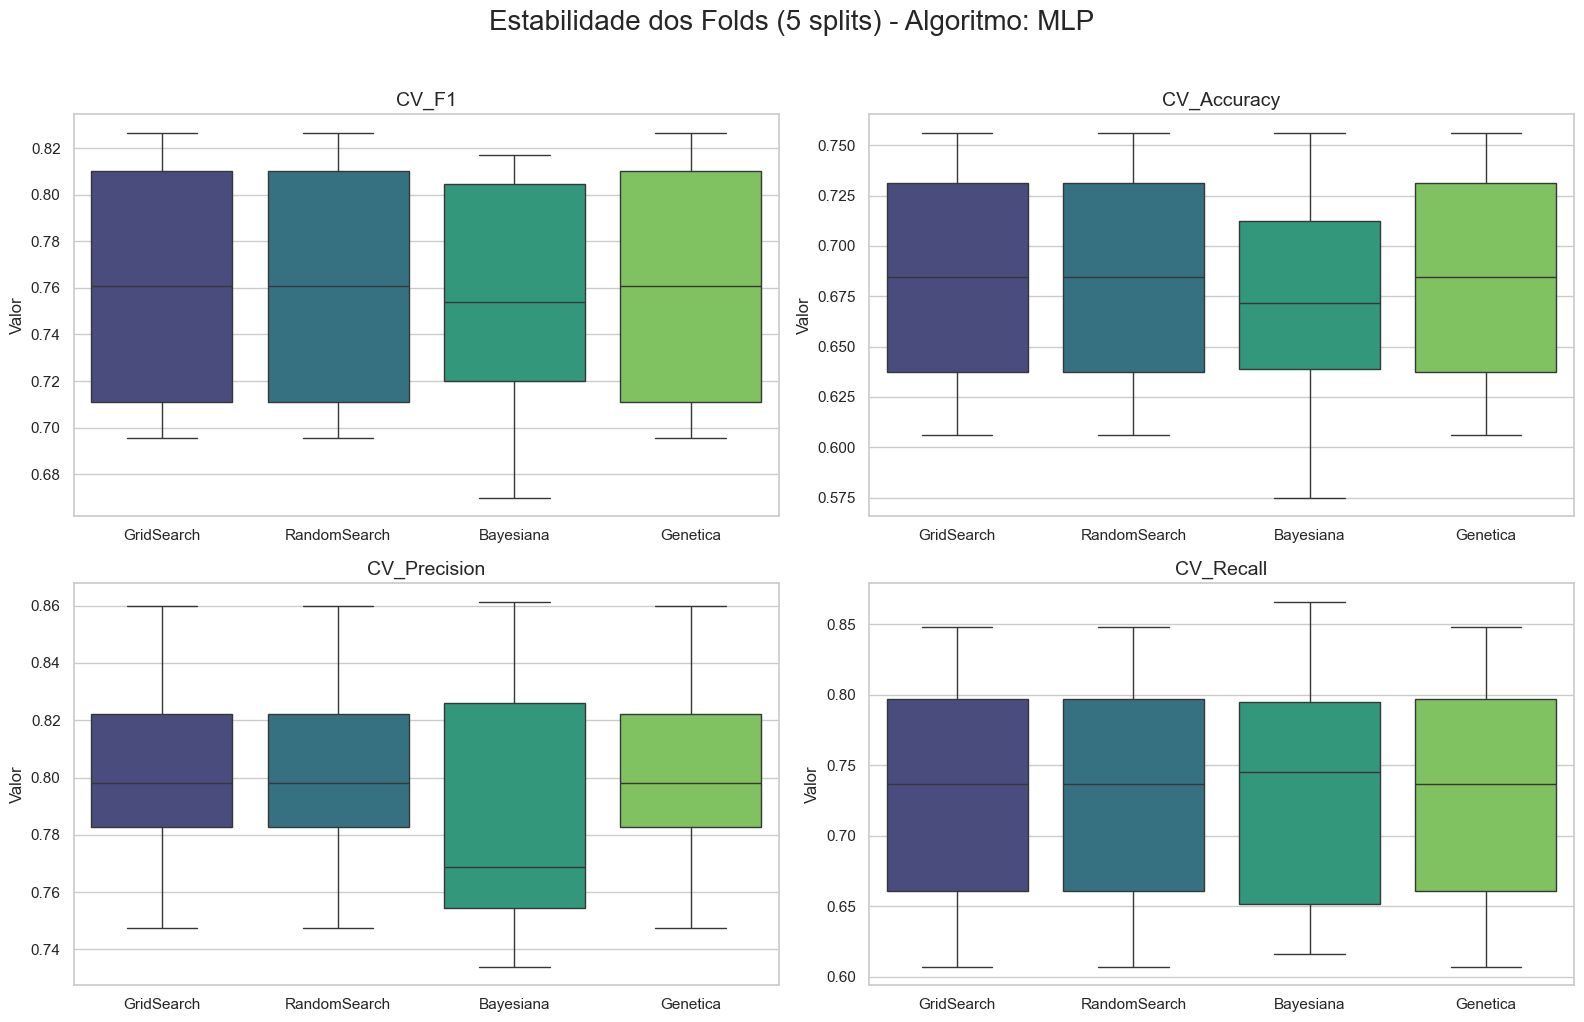

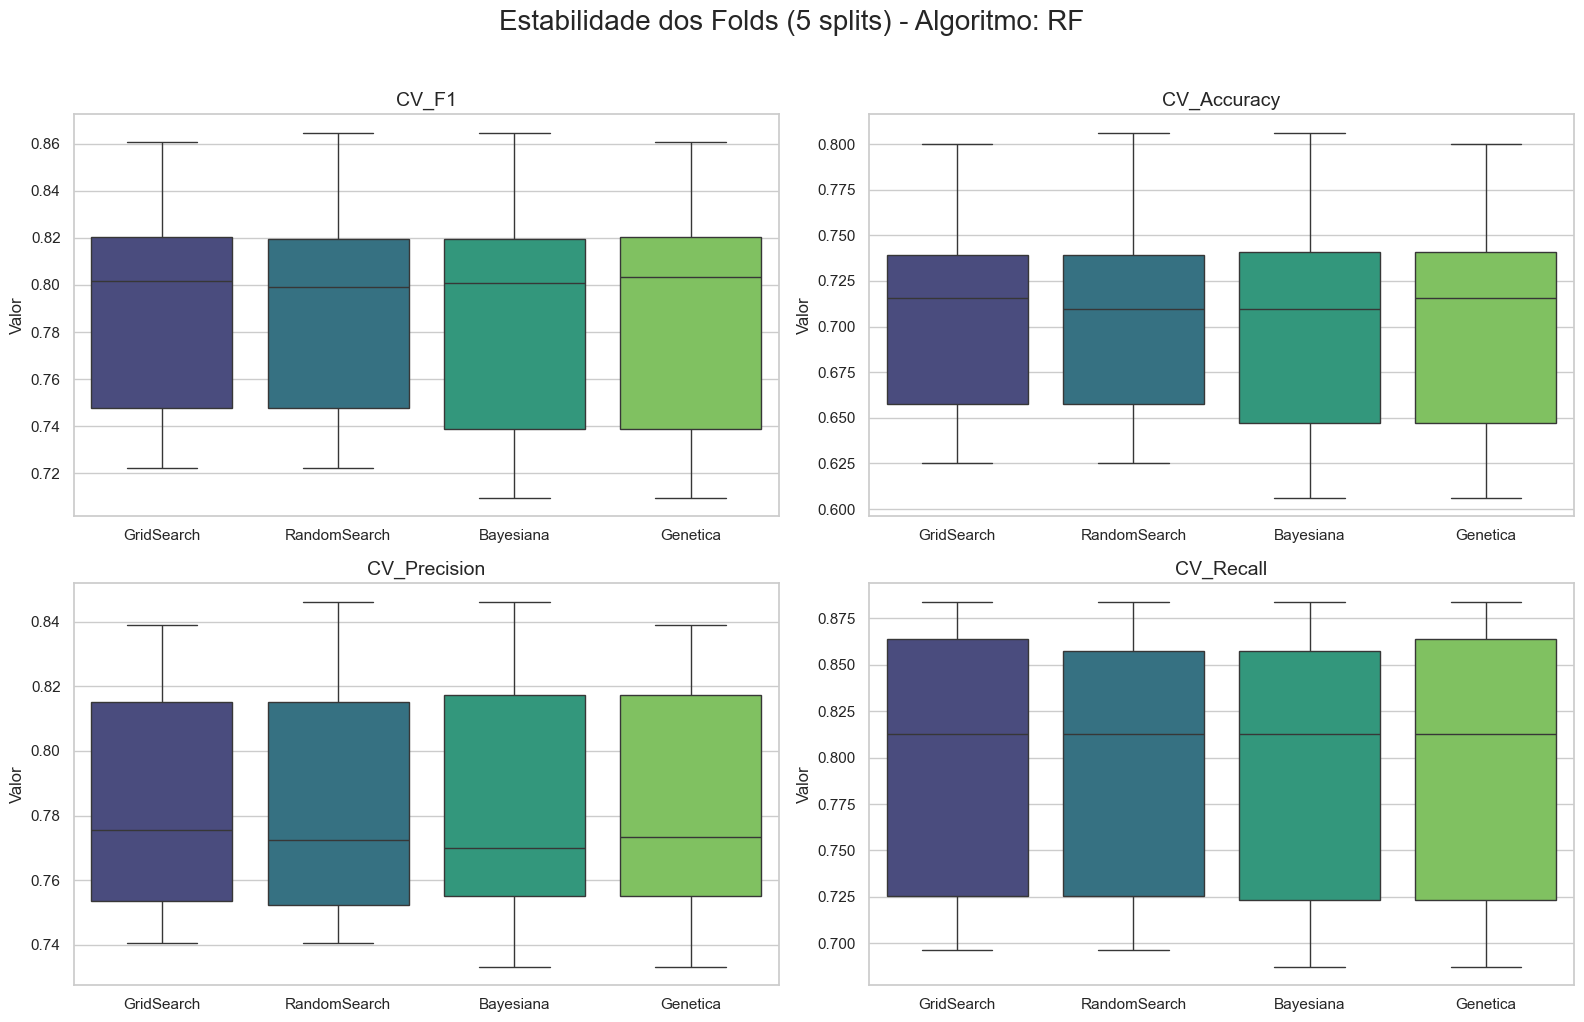

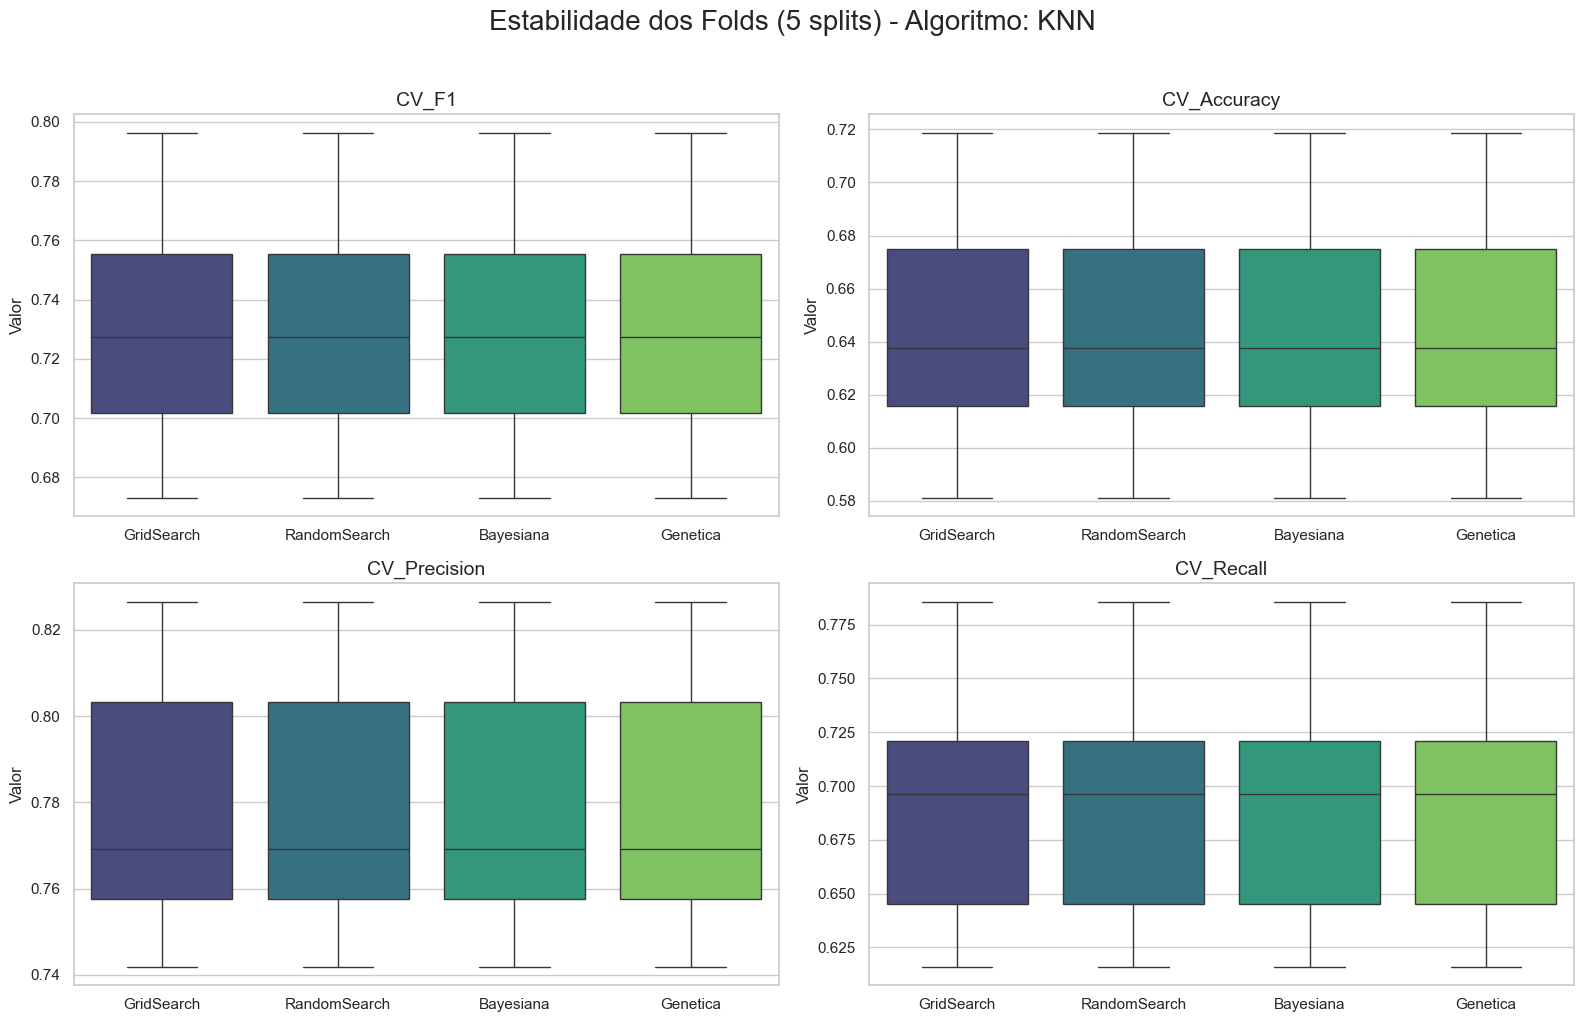

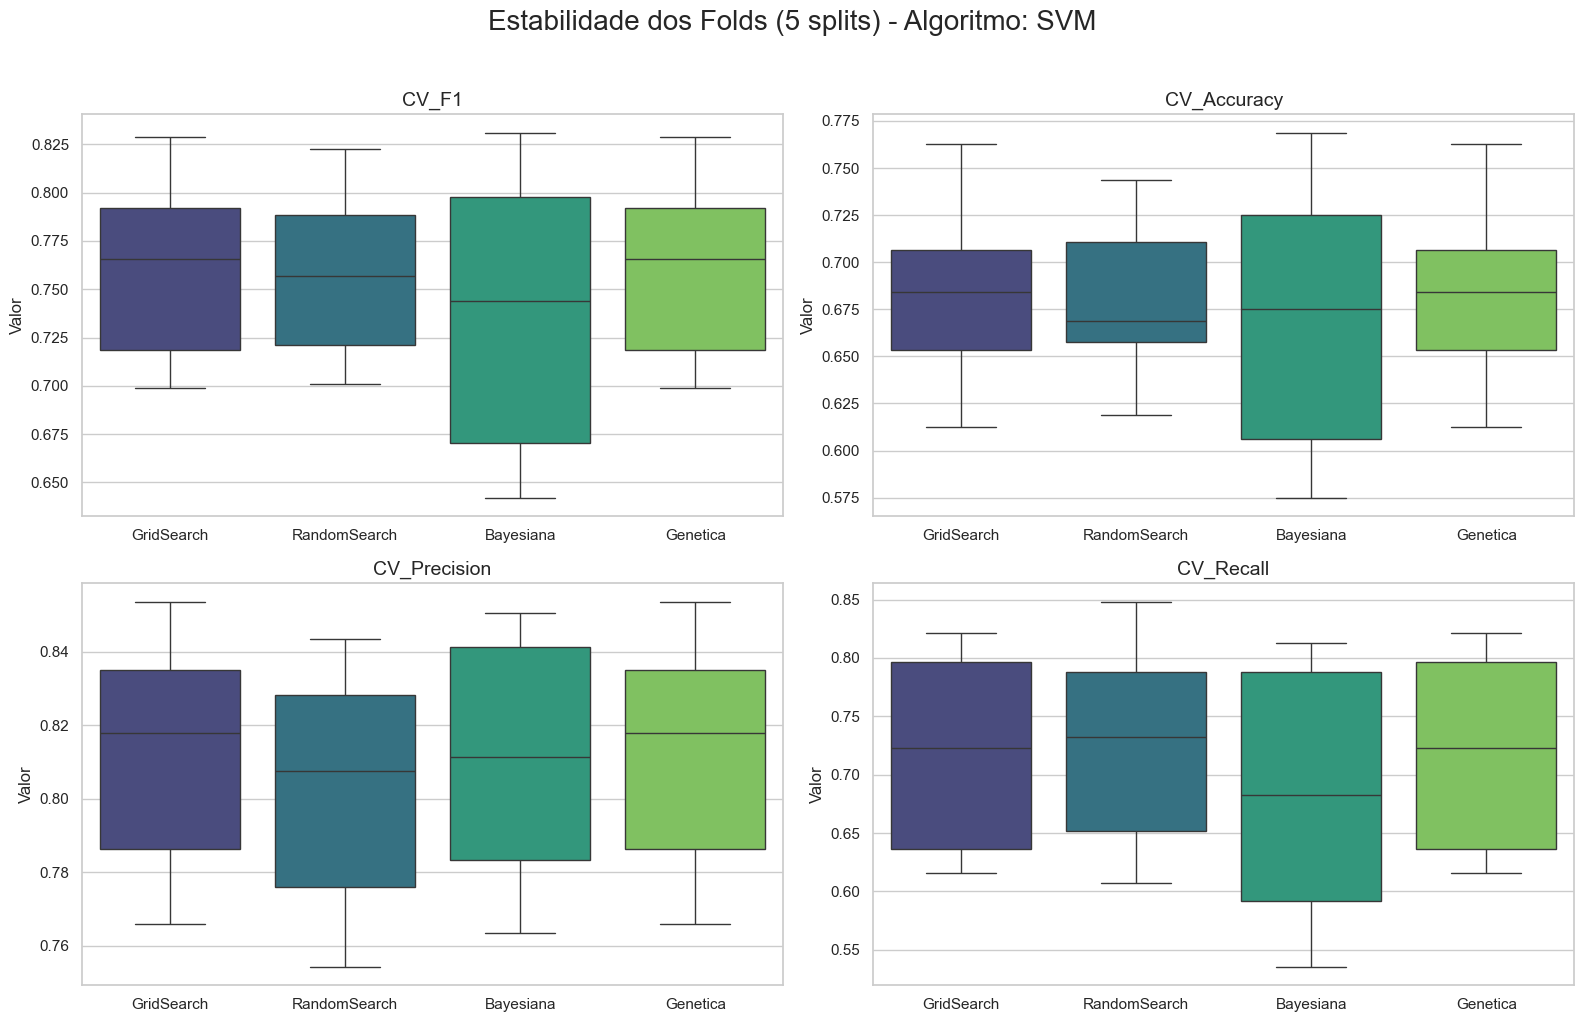

In [ ]:
for algoritmo in df_resultados_resumo['Algoritmo'].unique():
    df_alg = df_resultados_folds[df_resultados_folds['Algoritmo'] == algoritmo]
    fig, axes = plt.subplots(2, 2, figsize=(16, 10))
    axes = axes.flatten()
    tipos_metricas = ['CV_F1', 'CV_Accuracy', 'CV_Precision', 'CV_Recall']
    
    for i, metrica in enumerate(tipos_metricas):
        sns.boxplot(
            data=df_alg,
            x="Otimizador",      
            y=metrica,
            hue="Otimizador",   
            ax=axes[i],         
            palette="viridis",
            legend=False        
        )
        
        # Ajustes visuais de cada subplot
        axes[i].set_title(f"{metrica}", fontsize=14)
        axes[i].set_xlabel("") 
        axes[i].set_ylabel("Valor")

    plt.suptitle(f"Estabilidade dos Folds (5 splits) - Algoritmo: {algoritmo}", fontsize=20, y=1.02)
    
    plt.tight_layout()
    plt.show()

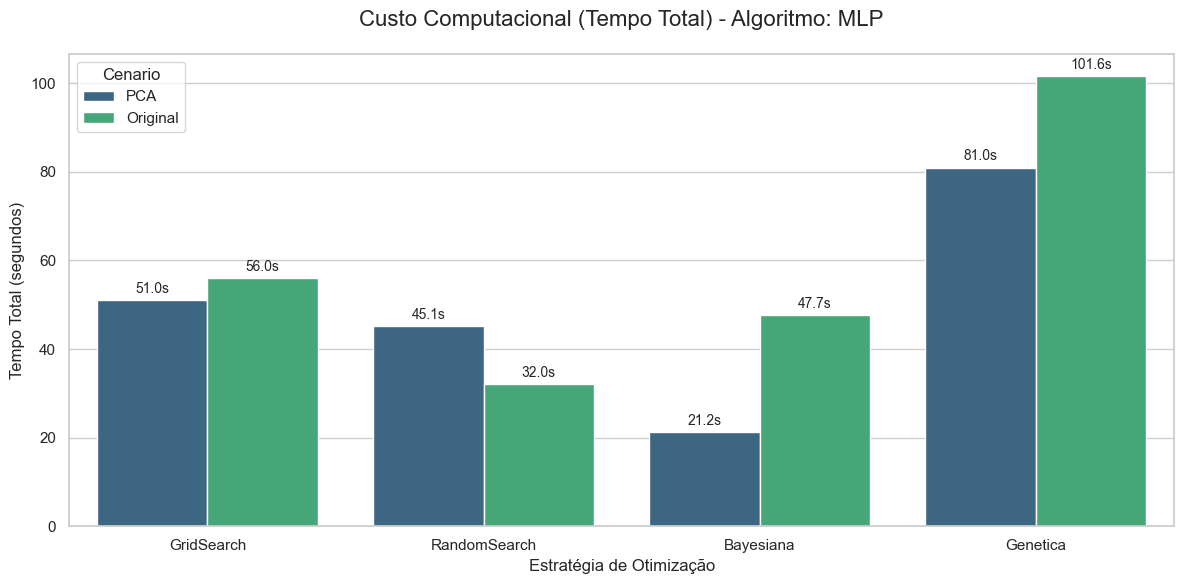

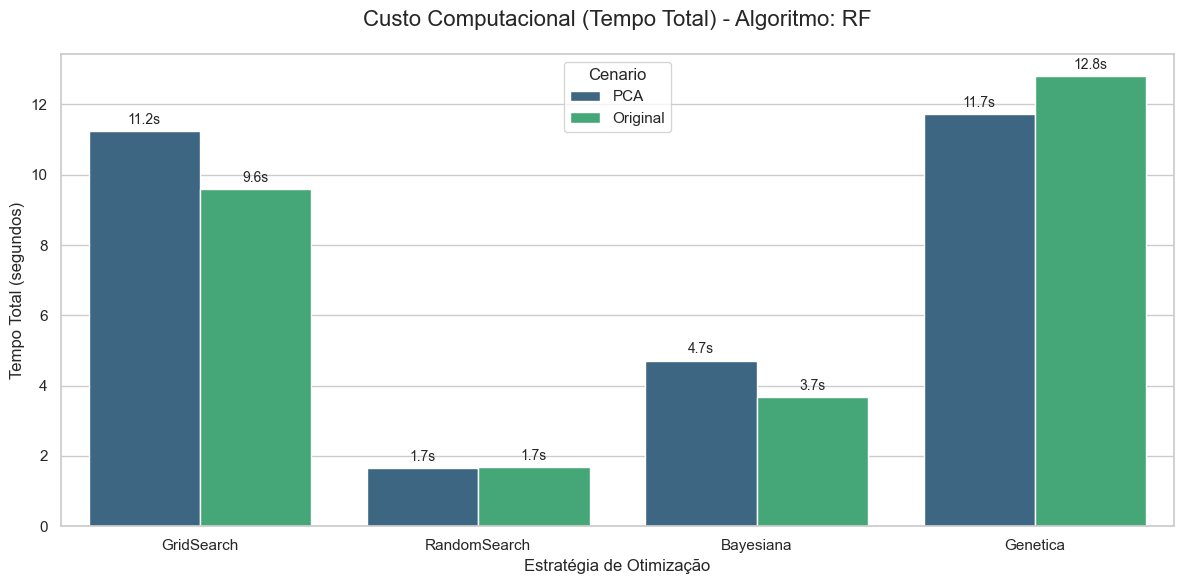

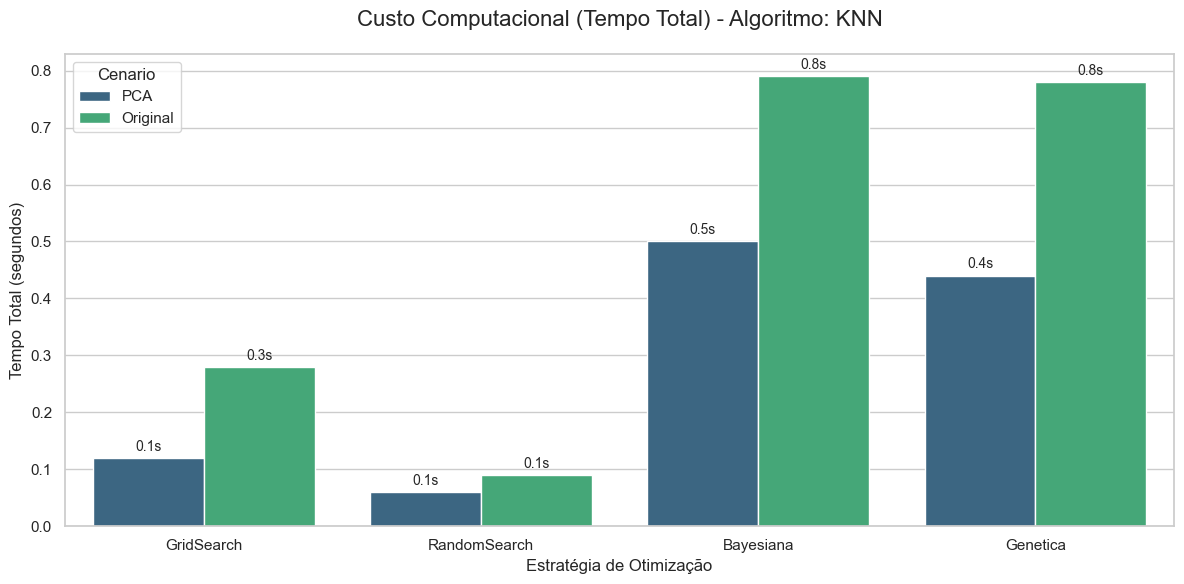

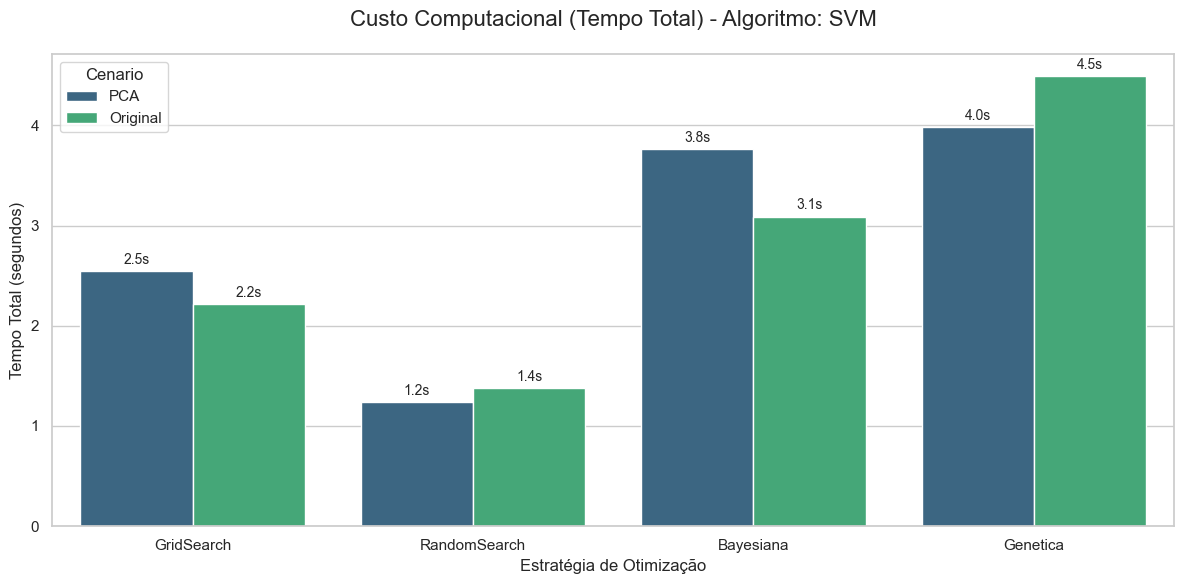

In [17]:
for algoritmo in df_resultados_resumo['Algoritmo'].unique():
    plt.figure(figsize=(12, 6))
    df_plot = df_resultados_resumo[df_resultados_resumo['Algoritmo'] == algoritmo]
    
    ax = sns.barplot(
        data=df_plot,
        x="Otimizador",
        y="Tempo_Total_s",
        hue="Cenario", # Certifique-se que essa coluna existe no seu DF de resumo
        palette="viridis"
    )

    for container in ax.containers:
        ax.bar_label(container, fmt='%.1fs', padding=3, fontsize=10)

    plt.title(f"Custo Computacional (Tempo Total) - Algoritmo: {algoritmo}", fontsize=16, pad=20)
    plt.ylabel("Tempo Total (segundos)")
    plt.xlabel("Estratégia de Otimização")
    plt.tight_layout()
    plt.show()